<a href="https://colab.research.google.com/github/1eetnals/Body-Morphometry-kidney-and-tumor/blob/main/unetr_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    EnsureType,
    ToTensord,
    MapTransform,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)
from monai.apps import download_and_extract

import torch

print_config()

MONAI version: 0.7.dev2131
Numpy version: 1.20.1
Pytorch version: 1.9.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 57467c75bff90e6c9da74461f7da3a828a39626b

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.1
scikit-image version: 0.18.1
Pillow version: 8.2.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.10.0
tqdm version: 4.59.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.8.0
pandas version: 1.2.4
einops version: 0.3.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [ ]:
root_dir='/home/hufsbme/gyu/.vscode/moai2021_train/'

In [ ]:
train_path = '/home/hufsbme/gyu/.vscode/moai2021_train/NIFTI/'
Input_folder = os.listdir(train_path)
train_files = []

for i in range(0,len(Input_folder)):
    if Input_folder[i].startswith('nifti'):
        data_file=os.listdir(train_path+Input_folder[i])
        for j in range(0,len(data_file)):
            if data_file[j].endswith('.nii.gz'):
                train_files.append(train_path+Input_folder[i]+'/'+data_file[j])

train_files.sort()
train_files

['/home/hufsbme/gyu/.vscode/moai2021_train/NIFTI/nifti_training001/ct_training001.nii.gz',
 '/home/hufsbme/gyu/.vscode/moai2021_train/NIFTI/nifti_training002/ct_training002.nii.gz',
 '/home/hufsbme/gyu/.vscode/moai2021_train/NIFTI/nifti_training003/ct_training003.nii.gz',
 '/home/hufsbme/gyu/.vscode/moai2021_train/NIFTI/nifti_training004/ct_training004.nii.gz',
 '/home/hufsbme/gyu/.vscode/moai2021_train/NIFTI/nifti_training005/ct_training005.nii.gz',
 '/home/hufsbme/gyu/.vscode/moai2021_train/NIFTI/nifti_training006/ct_training006.nii.gz',
 '/home/hufsbme/gyu/.vscode/moai2021_train/NIFTI/nifti_training007/ct_training007.nii.gz',
 '/home/hufsbme/gyu/.vscode/moai2021_train/NIFTI/nifti_training008/ct_training008.nii.gz',
 '/home/hufsbme/gyu/.vscode/moai2021_train/NIFTI/nifti_training009/ct_training009.nii.gz',
 '/home/hufsbme/gyu/.vscode/moai2021_train/NIFTI/nifti_training010/ct_training010.nii.gz',
 '/home/hufsbme/gyu/.vscode/moai2021_train/NIFTI/nifti_training011/ct_training011.nii.gz',

In [ ]:
train_label_path = '/home/hufsbme/gyu/.vscode/moai2021_train/Label_NIFTI'
Input_folder = os.listdir(train_label_path)
train_label_files = []

for i in range(0,len(Input_folder)):
    train_label_files.append(train_label_path+'/'+Input_folder[i])

train_label_files.sort()
train_label_files

['/home/hufsbme/gyu/.vscode/moai2021_train/Label_NIFTI/training001.nii.gz',
 '/home/hufsbme/gyu/.vscode/moai2021_train/Label_NIFTI/training002.nii.gz',
 '/home/hufsbme/gyu/.vscode/moai2021_train/Label_NIFTI/training003.nii.gz',
 '/home/hufsbme/gyu/.vscode/moai2021_train/Label_NIFTI/training004.nii.gz',
 '/home/hufsbme/gyu/.vscode/moai2021_train/Label_NIFTI/training005.nii.gz',
 '/home/hufsbme/gyu/.vscode/moai2021_train/Label_NIFTI/training006.nii.gz',
 '/home/hufsbme/gyu/.vscode/moai2021_train/Label_NIFTI/training007.nii.gz',
 '/home/hufsbme/gyu/.vscode/moai2021_train/Label_NIFTI/training008.nii.gz',
 '/home/hufsbme/gyu/.vscode/moai2021_train/Label_NIFTI/training009.nii.gz',
 '/home/hufsbme/gyu/.vscode/moai2021_train/Label_NIFTI/training010.nii.gz',
 '/home/hufsbme/gyu/.vscode/moai2021_train/Label_NIFTI/training011.nii.gz',
 '/home/hufsbme/gyu/.vscode/moai2021_train/Label_NIFTI/training012.nii.gz',
 '/home/hufsbme/gyu/.vscode/moai2021_train/Label_NIFTI/training013.nii.gz',
 '/home/hufs

In [ ]:
train_ind=np.arange(0,30)
data_dicts=[
    {
        "image": train_files[idx],
        "label": train_label_files[idx],
    }
    for idx in train_ind
]

train_f=data_dicts
len(train_f)
train_f

[{'image': '/home/hufsbme/gyu/.vscode/moai2021_train/NIFTI/nifti_training001/ct_training001.nii.gz',
  'label': '/home/hufsbme/gyu/.vscode/moai2021_train/Label_NIFTI/training001.nii.gz'},
 {'image': '/home/hufsbme/gyu/.vscode/moai2021_train/NIFTI/nifti_training002/ct_training002.nii.gz',
  'label': '/home/hufsbme/gyu/.vscode/moai2021_train/Label_NIFTI/training002.nii.gz'},
 {'image': '/home/hufsbme/gyu/.vscode/moai2021_train/NIFTI/nifti_training003/ct_training003.nii.gz',
  'label': '/home/hufsbme/gyu/.vscode/moai2021_train/Label_NIFTI/training003.nii.gz'},
 {'image': '/home/hufsbme/gyu/.vscode/moai2021_train/NIFTI/nifti_training004/ct_training004.nii.gz',
  'label': '/home/hufsbme/gyu/.vscode/moai2021_train/Label_NIFTI/training004.nii.gz'},
 {'image': '/home/hufsbme/gyu/.vscode/moai2021_train/NIFTI/nifti_training005/ct_training005.nii.gz',
  'label': '/home/hufsbme/gyu/.vscode/moai2021_train/Label_NIFTI/training005.nii.gz'},
 {'image': '/home/hufsbme/gyu/.vscode/moai2021_train/NIFTI/n

In [ ]:
val_ind=np.arange(40,50)
data_dicts=[
    {
       "image": train_files[idx],
        "label": train_label_files[idx],
    }
    for idx in val_ind
]

val_f=data_dicts
len(val_f)
val_f

[{'image': '/home/hufsbme/gyu/.vscode/moai2021_train/NIFTI/nifti_training041/ct_training041.nii.gz',
  'label': '/home/hufsbme/gyu/.vscode/moai2021_train/Label_NIFTI/training041.nii.gz'},
 {'image': '/home/hufsbme/gyu/.vscode/moai2021_train/NIFTI/nifti_training042/ct_training042.nii.gz',
  'label': '/home/hufsbme/gyu/.vscode/moai2021_train/Label_NIFTI/training042.nii.gz'},
 {'image': '/home/hufsbme/gyu/.vscode/moai2021_train/NIFTI/nifti_training043/ct_training043.nii.gz',
  'label': '/home/hufsbme/gyu/.vscode/moai2021_train/Label_NIFTI/training043.nii.gz'},
 {'image': '/home/hufsbme/gyu/.vscode/moai2021_train/NIFTI/nifti_training044/ct_training044.nii.gz',
  'label': '/home/hufsbme/gyu/.vscode/moai2021_train/Label_NIFTI/training044.nii.gz'},
 {'image': '/home/hufsbme/gyu/.vscode/moai2021_train/NIFTI/nifti_training045/ct_training045.nii.gz',
  'label': '/home/hufsbme/gyu/.vscode/moai2021_train/Label_NIFTI/training045.nii.gz'},
 {'image': '/home/hufsbme/gyu/.vscode/moai2021_train/NIFTI/n

In [ ]:
class ConvertToMultiChannel(MapTransform):
    """
    Convert labels to multi channels:
    """
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            result.append(d[key].astype(np.int8) >0)
#            result.append(d[key].astype(np.int8) == 1)
#            result.append(d[key].astype(np.int8) == 2)
#            result.append(d[key].astype(np.int8) == 4)
            d[key] = np.stack(result, axis=0).astype(np.float32)
        return d

In [ ]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image"]),
        ConvertToMultiChannel(keys=["label"]), 
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.7, 1.7, 1.7),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image"], axcodes="RAS"),
        Orientationd(keys=["label"], axcodes="RPS"),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-285,
            a_max=350,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 32),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
       # removed random agmentation
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=["image"]),
        ConvertToMultiChannel(keys=["label"]), 
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.7, 1.7, 1.7),
            mode=("bilinear", "nearest"),
        ),
        Orientationd(keys=["image"], axcodes="RAS"),
        Orientationd(keys=["label"], axcodes="RPS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-285, a_max=350, b_min=0.0, b_max=1.0, clip=True
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        ToTensord(keys=["image", "label"]),
    ]
)

In [ ]:
from monai.transforms import LoadImage
for i in range(len(train_f)):
    data, meta = LoadImage()(train_f[i]['image'])
    label,label_meta=LoadImage()(train_f[i]['label'])
    print(f"image data shape:{data.shape}")
    print(f"label data shape:{label.shape}")
    #print(f"meta data:{meta}")
    print('####')

image data shape:(512, 512, 64)
label data shape:(512, 512, 64)
####
image data shape:(512, 512, 64)
label data shape:(512, 512, 64)
####
image data shape:(512, 512, 64)
label data shape:(512, 512, 64)
####
image data shape:(512, 512, 64)
label data shape:(512, 512, 64)
####
image data shape:(512, 512, 64)
label data shape:(512, 512, 64)
####
image data shape:(512, 512, 64)
label data shape:(512, 512, 64)
####
image data shape:(512, 512, 64)
label data shape:(512, 512, 64)
####
image data shape:(512, 512, 64)
label data shape:(512, 512, 64)
####
image data shape:(512, 512, 64)
label data shape:(512, 512, 64)
####
image data shape:(512, 512, 64)
label data shape:(512, 512, 64)
####


In [ ]:
from monai.transforms import LoadImage

label,label_meta=LoadImage()(train_f[0]['label'])
np.count_nonzero( label== 2)

6705

In [ ]:
train_ds = CacheDataset(
    data=train_f,
    transform=train_transforms,
    #cache_num=24, 
    # It is recommended to experiment with different cache_num or cache_rate to identify the best training speed.
    cache_rate=1.0,
    num_workers=0,
)
train_loader = DataLoader(
    train_ds, batch_size=2, shuffle=True, num_workers=0, pin_memory=True
)

val_ds = CacheDataset(
    data=val_f, transform=val_transforms, cache_num=10, cache_rate=1.0, num_workers=0
)
val_loader = DataLoader(
    val_ds, batch_size=1, shuffle=False, num_workers=0, pin_memory=True
)

Loading dataset: 100%|██████████| 10/10 [00:19<00:00,  1.91s/it]


In [ ]:
val_ds[0]["image_meta_dict"]

{'sizeof_hdr': array(348, dtype=int32),
 'extents': array(0, dtype=int32),
 'session_error': array(1, dtype=int16),
 'dim_info': array(0, dtype=uint8),
 'dim': array([  3, 512, 512,  64,   1,   1,   1,   1], dtype=int16),
 'intent_p1': array(0., dtype=float32),
 'intent_p2': array(0., dtype=float32),
 'intent_p3': array(0., dtype=float32),
 'intent_code': array(0, dtype=int16),
 'datatype': array(4, dtype=int16),
 'bitpix': array(16, dtype=int16),
 'slice_start': array(0, dtype=int16),
 'pixdim': array([1., 1., 1., 1., 0., 0., 0., 0.], dtype=float32),
 'vox_offset': array(0., dtype=float32),
 'scl_slope': array(nan, dtype=float32),
 'scl_inter': array(nan, dtype=float32),
 'slice_end': array(0, dtype=int16),
 'slice_code': array(0, dtype=uint8),
 'xyzt_units': array(10, dtype=uint8),
 'cal_max': array(0., dtype=float32),
 'cal_min': array(0., dtype=float32),
 'slice_duration': array(0., dtype=float32),
 'toffset': array(0., dtype=float32),
 'glmax': array(0, dtype=int32),
 'glmin': arr

image shape: torch.Size([1, 293, 244, 38]), label shape: torch.Size([1, 293, 244, 38])


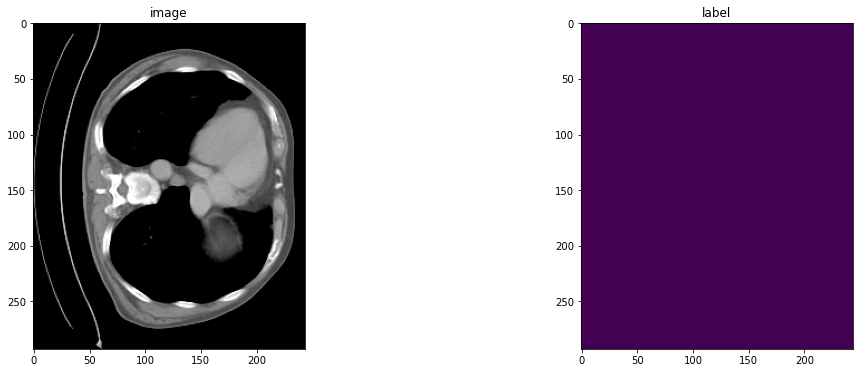

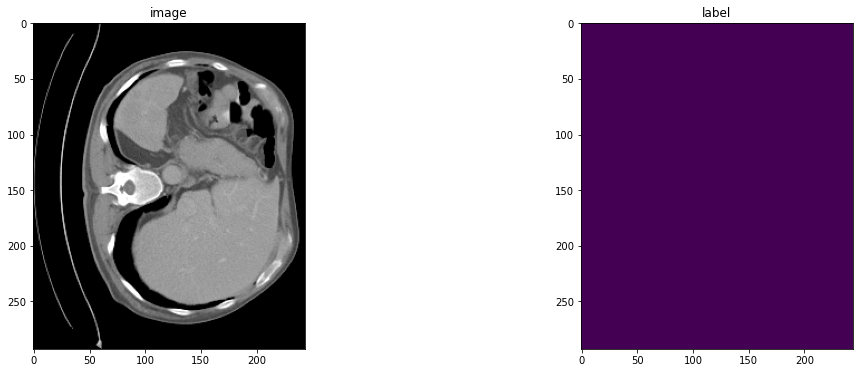

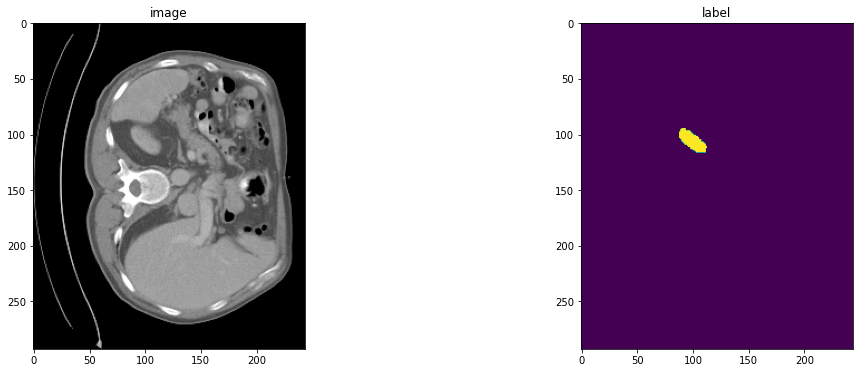

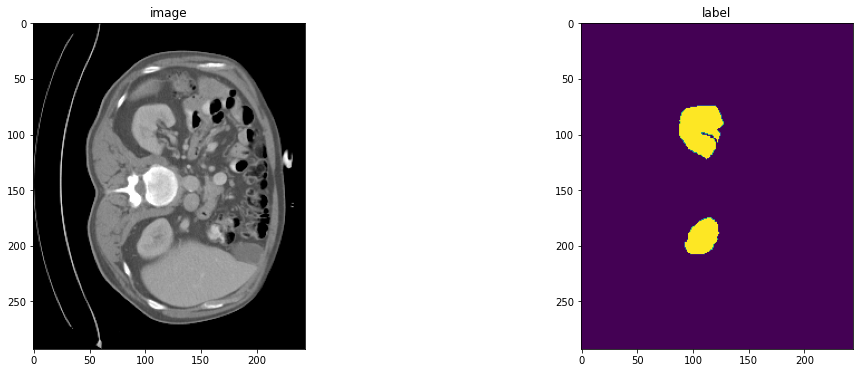

In [ ]:
case_num = 0
#img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
for i in range(0,4):
  plt.figure("image", (18, 6))
  plt.subplot(1, 2, 1)
  plt.title("image")
  plt.imshow(img[0, :, :, i*5+1].detach().cpu(), cmap="gray")
  plt.subplot(1, 2, 2)
  plt.title("label")
  plt.imshow(label[0, :, :, i*5+1].detach().cpu())
  plt.show()

In [ ]:
for val_image in val_loader:
  print(val_image['image'].shape)

torch.Size([1, 1, 293, 244, 32])
torch.Size([1, 1, 281, 259, 32])
torch.Size([1, 1, 278, 253, 32])
torch.Size([1, 1, 302, 253, 32])
torch.Size([1, 1, 246, 200, 32])
torch.Size([1, 1, 284, 254, 32])
torch.Size([1, 1, 296, 255, 32])
torch.Size([1, 1, 274, 262, 32])
torch.Size([1, 1, 285, 233, 32])
torch.Size([1, 1, 302, 287, 32])


torch.Size([8, 1, 96, 96, 32])


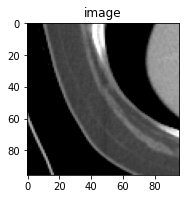

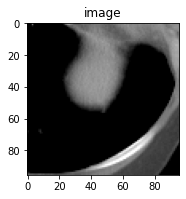

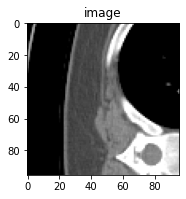

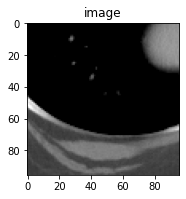

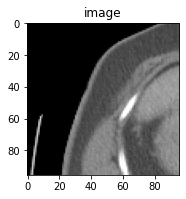

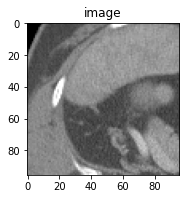

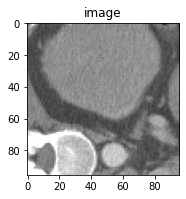

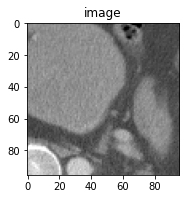

torch.Size([8, 1, 96, 96, 32])


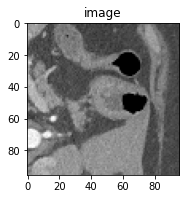

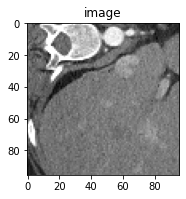

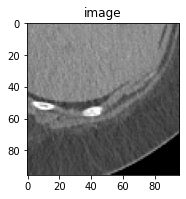

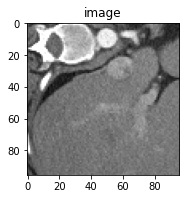

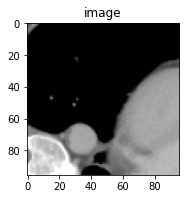

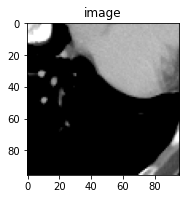

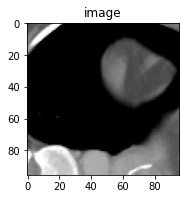

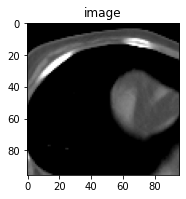

torch.Size([8, 1, 96, 96, 32])


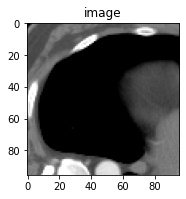

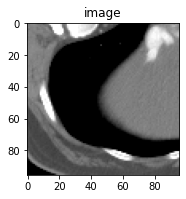

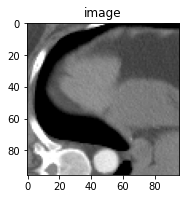

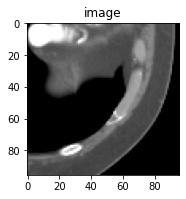

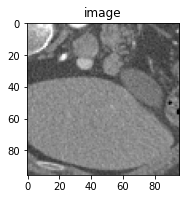

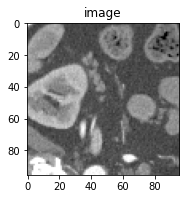

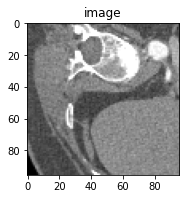

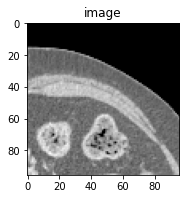

In [ ]:
j=0
for train_image in train_loader:
  print(train_image['image'].shape)
  for i in range(8):
    image=train_image['image'][i]
    plt.figure("check", (6,6))
    plt.subplot(1,2,1)
    plt.title("image")
    plt.imshow(image[0,:,:,0], cmap="gray")
    plt.show()
  j+=1
  if j==3:
    break

In [ ]:
device = torch.device("cuda:1")
!nvidia-smi

Thu Aug 26 21:09:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:3B:00.0 Off |                  N/A |
| 27%   31C    P8    19W / 250W |   1047MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:AF:00.0 Off |                  N/A |
| 27%   

In [ ]:
pip install einops

Note: you may need to restart the kernel to use updated packages.


In [ ]:
model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

in_channels=1,
    out_channels=3, #classes
    img_size=(96, 96, 32),
    feature_size=8, #16
    hidden_size=384, #768
    mlp_dim=1536, #3072
    num_heads=12,
    pos_embed="perceptron", #perceptron
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
    lr=1e-4, weight_decay=1e-5
    max_iterations = 50
    eval_num = 5
    train completed, best_metric: 0.0086 at iteration: 5
    //
        in_channels=1,
    out_channels=3, #classes
    img_size=(96, 96, 32),
    feature_size=8, #16
    hidden_size=384, #768
    mlp_dim=1536, #3072
    num_heads=12,
    pos_embed="perceptron", #perceptron
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
    lr=1e-5, weight_decay=1e-5
    max_iterations = 200
eval_num = 10
train completed, best_metric: 0.3352 at iteration: 200

In [ ]:
max_epochs = 500
val_interval = 10
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, n_classes=2)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, n_classes=2)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model_v1.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/500
1/15, train_loss: 0.6268
2/15, train_loss: 0.6338
3/15, train_loss: 0.6265
4/15, train_loss: 0.6217
5/15, train_loss: 0.6154
6/15, train_loss: 0.6301
7/15, train_loss: 0.6096
8/15, train_loss: 0.5612
9/15, train_loss: 0.6222
10/15, train_loss: 0.6100
11/15, train_loss: 0.6037
12/15, train_loss: 0.5885
13/15, train_loss: 0.5595
14/15, train_loss: 0.6142
15/15, train_loss: 0.5869
epoch 1 average loss: 0.6073
----------
epoch 2/500
1/15, train_loss: 0.5844
2/15, train_loss: 0.5631
3/15, train_loss: 0.5413
4/15, train_loss: 0.5838
5/15, train_loss: 0.5803
6/15, train_loss: 0.6135
7/15, train_loss: 0.5725
8/15, train_loss: 0.5851
9/15, train_loss: 0.5503
10/15, train_loss: 0.6067
11/15, train_loss: 0.5509
12/15, train_loss: 0.5777
13/15, train_loss: 0.5763
14/15, train_loss: 0.6005
15/15, train_loss: 0.6028
epoch 2 average loss: 0.5793
----------
epoch 3/500
1/15, train_loss: 0.5873
2/15, train_loss: 0.5695
3/15, train_loss: 0.5813
4/15, train_loss: 0.5398
5/15, train

In [ ]:
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.8663 at epoch: 390


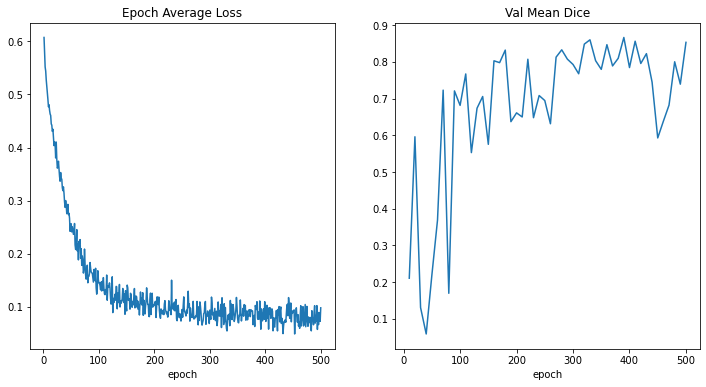

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

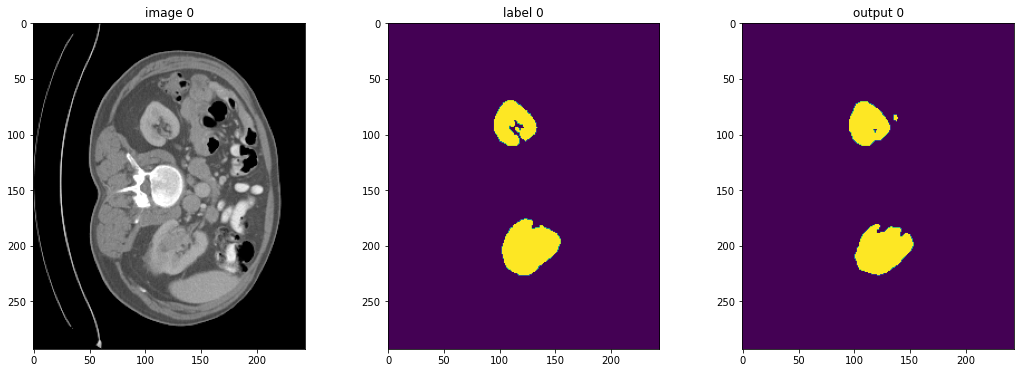

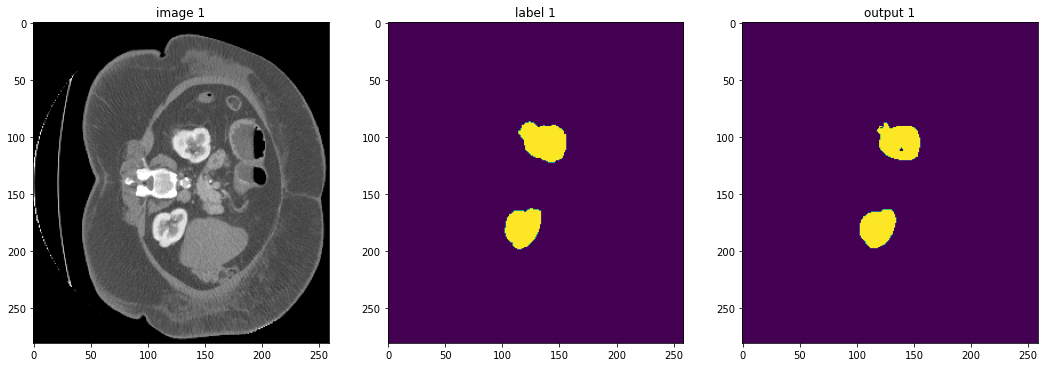

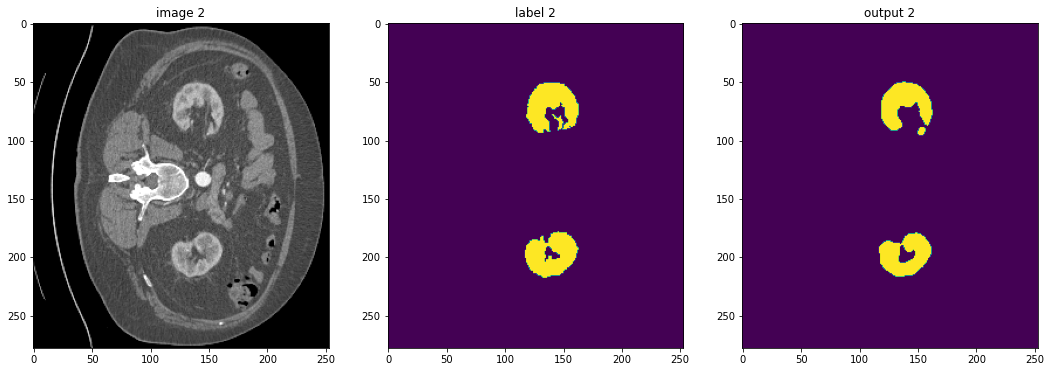

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model_v1.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model
        )
        # plot the slice [:, :, 80]
        sl=20
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, sl], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, sl])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, sl])
        plt.show()
        if i == 2:
            break